# Modelo de Árvores de Decisão (Naufrágio do Titanic)

##### Bibliotecas importadas

In [664]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import plotly.offline as pof
import plotly.graph_objs as pgo
import plotly.tools as pto
import sklearn as skt
import PIL

from IPython.display import Image

pof.init_notebook_mode(connected=True)

##### Aquisição e tratamento de dados

In [665]:
test_file = pd.read_csv('test.csv')
train_file = pd.read_csv('train.csv')
df_train = pd.DataFrame(train_file)
df_test = pd.DataFrame(test_file)

In [666]:
# conversão de qualified features em categorized features
# as qualified features serão transformadas em tabelas booleanas

##### Busca por valores Null ou vazios

Os vazios são interpretados como buracos no modelo que precisam ser tratados ou substituídos, ou removidos, dependendo da situação, no caso presente, os dados foram substituídos com a média da própria idade dos passageiros.

In [667]:
nulos = {'train': df_train.isnull().sum().sort_values(ascending=False), 'test': df_test.isnull().sum().sort_values(ascending=False)}
nulos_df = pd.DataFrame(nulos)
nulos_df

,train,test
Age,177,86.0
Cabin,687,327.0
Embarked,2,0.0
Fare,0,1.0
Name,0,0.0
Parch,0,0.0
PassengerId,0,0.0
Pclass,0,0.0
Sex,0,0.0
SibSp,0,0.0


In [668]:
df_train['Age'].fillna(df_train['Age'].mean(), inplace=True)
df_test['Age'].fillna(df_test['Age'].mean(), inplace=True)
df_test['Fare'].fillna(df_test['Fare'].mean(), inplace=True)

# Quantificação de parentes por membro da tripulação
df_train['Family Members'] = df_train.loc[0:, ['Parch', 'SibSp']].sum(axis=1)
df_test['Family Members'] = df_test.loc[0:, ['Parch', 'SibSp']].sum(axis=1)

all_data = pd.merge(df_train, df_test, how='outer')

df_train.drop(['Parch', 'SibSp','PassengerId', 'Ticket', 'Name'], axis=1, inplace=True)
df_test.drop(['Parch', 'SibSp', 'Ticket', 'Name', 'PassengerId'], axis=1, inplace=True)

# identificação se o passageiro teve cabine ou não
pointer = []
for item in df_train['Cabin']:
    if type(item) is float:
        pointer.append(0)
    else:
        pointer.append(1)
df_train['Has Cabin'] = pointer
df_train.drop(['Cabin'], axis=1, inplace=True)

pointer.clear()
for item in df_test['Cabin']:
    if type(item) is float:
        pointer.append(0)
    else:
        pointer.append(1)
df_test['Has Cabin'] = pointer
df_test.drop(['Cabin'], axis=1, inplace=True)

pointer.clear()

for index, item in enumerate(df_train['Embarked']):
    if type(item) == str:
        pointer.append(item)
    else:
        pointer.append(0)
        df_train.drop(index=index, axis=0, inplace=True)

Quantos familiares estavam embarcados por pessoa?

In [669]:
nulos = {
'Test': df_test.isnull().sum().sort_values(ascending=False),
'Train': df_train.isnull().sum().sort_values(ascending=False)
}
nulos_df = pd.DataFrame(nulos)
nulos_df
# sem valores nulos

,Test,Train
Age,0.0,0
Embarked,0.0,0
Family Members,0.0,0
Fare,0.0,0
Has Cabin,0.0,0
Pclass,0.0,0
Sex,0.0,0
Survived,NaN,0


In [670]:
new_data_train = pd.get_dummies(df_train)
new_data_test = pd.get_dummies(df_test)

<AxesSubplot:title={'center':'Mapa de Calor: Correlações entre os componentes'}>

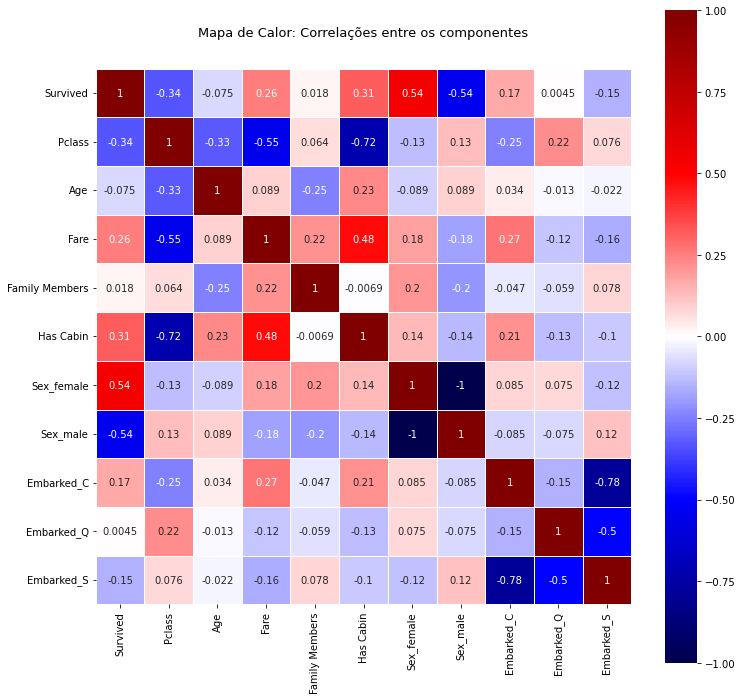

In [671]:
colormap = plt.cm.seismic
plt.figure(figsize=(12,12))
plt.title('Mapa de Calor: Correlações entre os componentes', y=1.05, size=13)
sns.heatmap(new_data_train.astype(float).corr(),linewidths=0.5,vmax=1.0, vmin=-1, square=True, cmap=colormap, linecolor='white', annot=True)

##### Criando a Árvore de Decisão
Vamos definir as features para o modelo e o seu target

In [672]:
Y = new_data_train['Survived']
X = new_data_train.drop(['Survived'], axis=1)

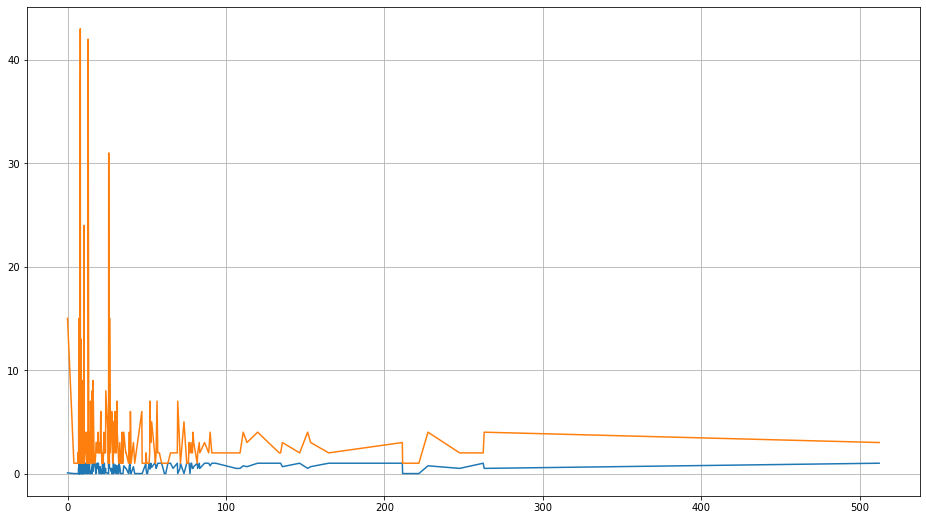

In [673]:
farexsurvived = new_data_train[['Fare','Survived']].groupby(['Fare'], as_index=False).agg(['mean', 'count'])

plt.figure(figsize=(16, 9))
plt.plot(farexsurvived)
plt.grid()
plt.show()

In [674]:
survived = new_data_train[['Sex_male', 'Sex_female','Survived']].groupby(['Survived'], as_index=False).agg(['mean', 'count'])
survived

Sex_male       Sex_female      
              mean count       mean count
Survived                                 
0         0.852459   549   0.147541   549
1         0.320588   340   0.679412   340

Criando o modelo

In [675]:
tree = skt.tree.DecisionTreeClassifier(max_depth=8, random_state=0)
tree.fit(X, Y)

DecisionTreeClassifier(max_depth=8, random_state=0)

In [676]:
tree.score(X, Y)

0.8953880764904387